# Posture Detection

### ViTPose Setup/Tutorial
Tutorial Link: https://huggingface.co/docs/transformers/en/model_doc/vitpose

In [10]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"

url = "http://images.cocodataset.org/val2017/000000000139.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose any detector of your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base")

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

dataset_index = torch.tensor([0], device=device) # must be a tensor of shape (batch_size,)

with torch.no_grad():
    outputs = model(**inputs, dataset_index=dataset_index)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]  # results for first image

In [11]:
import supervision as sv

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()

key_points = sv.KeyPoints(
    xy=xy, confidence=scores
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=1
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=2
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)

In [12]:
print(xy.shape)       # should be (N, K, 2)
print(scores.shape)   # should be (N, K)

(2, 17, 2)
(2, 17)


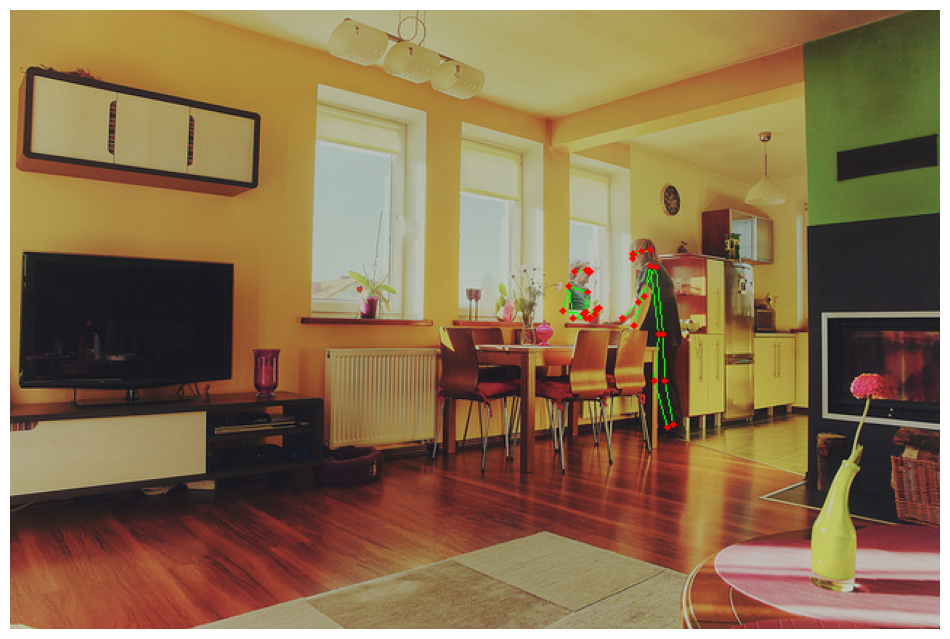

In [13]:
# Display the annotated image
sv.plot_image(annotated_frame)